In [1]:
#7장 물류 네트워크 최적 설계를 위한 테크닉 10

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

#데이터 불러오기
df_tr = pd.read_csv('trans_route.csv', index_col="공장")
df_pos = pd.read_csv('trans_route_pos.csv')

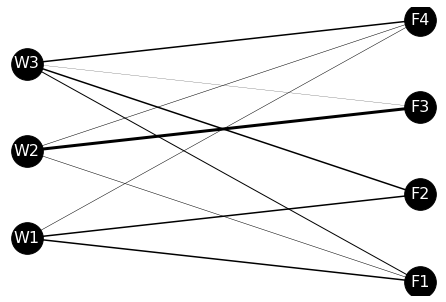

In [2]:
# 객체 생성
G = nx.Graph()

# 노드 설정
for i in range(len(df_pos.columns)):
    G.add_node(df_pos.columns[i])


#엣지 설정 가중치 리스트화
num_pre = 0
edge_weights = []
size = 0.1
for i in range(len(df_pos.columns)):
    for j in range(len(df_pos.columns)):
        if not(i==j):
            #엣지추가
            G.add_edge(df_pos.columns[i],df_pos.columns[j])
            #엣지가중치 추가
            if num_pre<len(G.edges):
                num_pre = len(G.edges)
                weight = 0
                if (df_pos.columns[i] in df_tr.columns)and(df_pos.columns[j] in df_tr.index):
                    if df_tr[df_pos.columns[i]][df_pos.columns[j]]:
                        weight = df_tr[df_pos.columns[i]][df_pos.columns[j]]*size
                elif(df_pos.columns[j] in df_tr.columns)and(df_pos.columns[i] in df_tr.index):
                    if df_tr[df_pos.columns[j]][df_pos.columns[i]]:
                        weight = df_tr[df_pos.columns[j]][df_pos.columns[i]]*size
                edge_weights.append(weight)
        
#좌표 설정
pos = {}
for i in range(len(df_pos.columns)):
    node = df_pos.columns[i]
    pos[node] = (df_pos[node][0],df_pos[node][1])
    
#그리기
nx.draw(G, pos, with_labels=True,font_size=16, node_size = 1000, node_color="k", font_color='w', width=edge_weights)

#표시
plt.show()

In [7]:
import pandas as pd

df_tr = pd.read_csv('trans_route.csv', index_col="공장")
df_tc = pd.read_csv('trans_cost.csv', index_col="공장")

def trans_cost(df_tr, df_tc):
    cost = 0
    for i in range(len(df_tc.index)):
        for j in range(len(df_tr.columns)):
            cost += df_tr.iloc[i][j]*df_tc.iloc[i][j]
    return cost

print("총 운송 비용:"+str(trans_cost(df_tr,df_tc)))

총 운송 비용:1493


In [8]:
import pandas as pd
import numpy as np

df_tr_new = pd.read_csv('trans_route_new.csv', index_col="공장")
print(df_tr_new)

#총운송비용 재계산
print("총 운송비용(변경 후):"+str(trans_cost(df_tr_new,df_tc)))

#제약 조건 계산 함수
#수요측
def condition_demand(df_tr,df_demand):
    flag = np.zeros(len(df_demand.columns))
    for i in range(len(df_demand.columns)):
        temp_sum = sum(df_tr[df_demand.columns[i]])
        if (temp_sum>=df_demand.iloc[0][i]):
            flag[i] = 1
    return flag

#공급측
def condition_supply(df_tr,df_supply):
    flag = np.zeros(len(df_supply.columns))
    for i in range(len(df_supply.columns)):
        temp_sum = sum(df_tr.loc[df_supply.columns[i]])
        if (temp_sum<=df_supply.iloc[0][i]):
            flag[i] = 1
    return flag

print("수요조건 계산결과:"+str(condition_demand(df_tr_new,df_demand)))
print("공급조건 계산결과:"+str(condition_supply(df_tr_new,df_supply)))

    F1  F2  F3  F4
공장                
W1  15  15   0   0
W2   5   0  30  10
W3  10  15   2  15
총 운송비용(변경 후):1428
수요조건 계산결과:[1. 1. 1. 1.]
공급조건 계산결과:[1. 0. 1.]


In [14]:
from itertools import product
from pulp import LpVariable, lpSum, value
from ortoolpy import model_min, addvars, addvals


In [15]:
#데이터 불러오기
df_tc = pd.read_csv('trans_cost.csv', index_col="공장")
df_demand = pd.read_csv('demand.csv')
df_supply = pd.read_csv('supply.csv')

#초기 설정
np.random.seed(1)
nw = len(df_tc.index)
nf = len(df_tc.columns)
pr = list(product(range(nw), range(nf)))

#수리 모델 작성
m1 = model_min()
v1 = {(i,j):LpVariable('v%d_%d'%(i,j),lowBound=0) for i,j in pr}

m1 += lpSum(df_tc.iloc[i][j]*v1[i,j] for i,j in pr)
for i in range(nw):
    m1 += lpSum(v1[i,j] for j in range(nf)) <= df_supply.iloc[0][i]
for j in range(nf):
    m1 += lpSum(v1[i,j] for i in range(nw)) >= df_demand.iloc[0][j]
m1.solve()

df_tr_sol = df_tc.copy()
total_cost = 0
for k,x in v1.items():
    i,j = k[0],k[1]
    df_tr_sol.iloc[i][j] = value(x)
    total_cost += df_tc.iloc[i][j]*value(x)
    
print(df_tr_sol)
print("총 운송 비용:"+str(total_cost))

    F1  F2  F3  F4
공장                
W1  28   7   0   0
W2   0   0  31   5
W3   0  22   0  20
총 운송 비용:1296.0


In [16]:
#데이터 불러오기
df_tc = pd.read_csv('trans_cost.csv', index_col="공장")
df_demand = pd.read_csv('demand.csv')
df_supply = pd.read_csv('supply.csv')


In [17]:
import pandas as pd
import numpy as np

df_demand = pd.read_csv('demand.csv')
df_supply = pd.read_csv('supply.csv')

#제약 조건 계산 함수
#수요측
def condition_demand(df_tr,df_demand):
    flag = np.zeros(len(df_demand.columns))
    for i in range(len(df_demand.columns)):
        temp_sum = sum(df_tr[df_demand.columns[i]])
        if (temp_sum>=df_demand.iloc[0][i]):
            flag[i] = 1
    return flag

#공급측
def condition_supply(df_tr,df_supply):
    flag = np.zeros(len(df_supply.columns))
    for i in range(len(df_supply.columns)):
        temp_sum = sum(df_tr.loc[df_supply.columns[i]])
        if (temp_sum<=df_supply.iloc[0][i]):
            flag[i] = 1
    return flag

print("수요조건 계산결과:"+str(condition_demand(df_tr_sol,df_demand)))
print("공급조건 계산결과:"+str(condition_supply(df_tr_sol,df_supply)))

수요조건 계산결과:[1. 1. 1. 1.]
공급조건 계산결과:[1. 1. 1.]


In [18]:
import pandas as pd

df_material = pd.read_csv('product_plan_material.csv', index_col="제품")
print(df_material)
df_profit = pd.read_csv('product_plan_profit.csv', index_col="제품")
print(df_profit)
df_stock = pd.read_csv('product_plan_stock.csv', index_col="항목")
print(df_stock)
df_plan = pd.read_csv('product_plan.csv', index_col="제품")
print(df_plan)

     원료1  원료2  원료3
제품                
제품1    1    4    3
제품2    2    4    1
      이익
제품      
제품1  5.0
제품2  4.0
    원료1  원료2  원료3
항목               
재고   40   80   50
      생산량
제품       
제품1    16
제품2     0


In [19]:
def product_plan(df_profit,df_plan):
    profit = 0
    for i in range(len(df_profit.index)):
        for j in range(len(df_plan.columns)):
            profit += df_profit.iloc[i][j]*df_plan.iloc[i][j]
        return profit
    
print("총 이익:"+str(product_plan(df_profit,df_plan)))

총 이익:80.0


In [20]:
import pandas as pd
from pulp import LpVariable, lpSum, value
from ortoolpy import model_max, addvars, addvals

In [22]:
df = df_material.copy()
inv = df_stock

m = model_max()
v1 = {(i):LpVariable('v%d'%(i),lowBound=0) for i in range(len(df_profit))}
m += lpSum(df_profit.iloc[i]*v1[i] for i in range(len(df_profit)))
for i in range(len(df_material.columns)):
    m += lpSum(df_material.iloc[j,i]*v1[j] for j in range(len(df_profit))) <= df_stock.iloc[:,i]
m.solve()
    
df_plan_sol = df_plan.copy()
for k,x in v1.items():
    df_plan_sol.iloc[k] = value(x)
print(df_plan_sol)
print("총 이익:"+str(value(m.objective)))

      생산량
제품       
제품1    15
제품2     5
총 이익:95.0


In [29]:
def condition_stock(df_plan, df_material, df_stock):
    flag = np.zeros(len(df_material.columns))
    for i in range(len(df_material.columns)):
        temp_sum = 0
        for j in range(len(df_material.index)):
            temp_sum = temp_sum + df_material.iloc[j][i]*float(df_plan.iloc[j])
        if (temp_sum<=float(df_stock.iloc[0][i])):
            flag[i] = 1
        print(df_material.columns[i]+" 사용량:"+str(temp_sum)+", 재고:"+str(float(df_stock.iloc[0][i])))
    return flag
        
print("제약 조건 계산 결과:"+str(condition_stock(df_plan_sol,df_material,df_stock)))

원료1 사용량:25.0, 재고:40.0
원료2 사용량:80.0, 재고:80.0
원료3 사용량:50.0, 재고:50.0
제약 조건 계산 결과:[1. 1. 1.]


In [37]:
import numpy as np
import pandas as pd

제품 = list('AB')
대리점 = list('PQ')
공장 = list('XY')
레인 = (2,2)

#운송비
tbdi = pd.DataFrame(((j,k) for j in 대리점 for k in 공장), columns=['대리점','공장'])
tbdi['운송비'] = [1,2,3,1]
print(tbdi)

#수요 
tbde = pd.DataFrame(((j,i) for j in 대리점 for i in 제품), columns=['대리점','제품'])
tbde['수요'] = [10,10,20,20]
print(tbde)

#생산
tbfa = pd.DataFrame(((k,l,i,0,np.inf) for k,nl in zip (공장,레인) for l in range(nl) for i in 제품), columns=['공장','레인','제품','하한','상한'])
tbfa['생산비'] = [1,np.nan,np.nan,1,3,np.nan,5,3]
tbfa.dropna(inplace=True)
tbfa.loc[4, '상한']=10
print(tbfa)
                    
from ortoolpy import logistics_network
_, tbdi2, _= logistics_network(tbde, tbdi, tbfa,dep ="대리점", dem = "수요",fac ="공장", prd = "제품",tcs = "운송비",pcs ="생산비", lwb = "하한", upb = "상한")
print(tbfa)
print(tbdi2)

  대리점 공장  운송비
0   P  X    1
1   P  Y    2
2   Q  X    3
3   Q  Y    1
  대리점 제품  수요
0   P  A  10
1   P  B  10
2   Q  A  20
3   Q  B  20
  공장  레인 제품  하한    상한  생산비
0  X   0  A   0   inf  1.0
3  X   1  B   0   inf  1.0
4  Y   0  A   0  10.0  3.0
6  Y   1  A   0   inf  5.0
7  Y   1  B   0   inf  3.0
  공장  레인 제품  하한    상한  생산비     VarY  ValY
0  X   0  A   0   inf  1.0  v000022  20.0
3  X   1  B   0   inf  1.0  v000023  10.0
4  Y   0  A   0  10.0  3.0  v000024  10.0
6  Y   1  A   0   inf  5.0  v000025   0.0
7  Y   1  B   0   inf  3.0  v000026  20.0
  대리점 공장  운송비 제품     VarX  ValX
0   P  X    1  A  v000014  10.0
1   P  X    1  B  v000015  10.0
2   Q  X    3  A  v000016  10.0
3   Q  X    3  B  v000017   0.0
4   P  Y    2  A  v000018   0.0
5   P  Y    2  B  v000019   0.0
6   Q  Y    1  A  v000020  10.0
7   Q  Y    1  B  v000021  20.0


C:\ProgramData\Anaconda3\lib\site-packages\ortoolpy\etc.py:1216: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  tbsm = pd.concat(


In [38]:
tbdi2 = tbdi2[["공장", "대리점", "운송비", "제품", "VarX", "ValX"]]
tbdi2

,공장,대리점,운송비,제품,VarX,ValX
0,X,P,1,A,v000014,10.0
1,X,P,1,B,v000015,10.0
2,X,Q,3,A,v000016,10.0
3,X,Q,3,B,v000017,0.0
4,Y,P,2,A,v000018,0.0
5,Y,P,2,B,v000019,0.0
6,Y,Q,1,A,v000020,10.0
7,Y,Q,1,B,v000021,20.0


In [39]:
trans_cost = 0
for i in range(len(tbdi2.index)):
    trans_cost += tbdi2["운송비"].iloc[i]*tbdi2["ValX"].iloc[i]
print("총 운송비:"+str(trans_cost))

총 운송비:80.0


In [40]:
tbfa

,공장,레인,제품,하한,상한,생산비,VarY,ValY
0,X,0,A,0,inf,1.0,v000022,20.0
3,X,1,B,0,inf,1.0,v000023,10.0
4,Y,0,A,0,10.0,3.0,v000024,10.0
6,Y,1,A,0,inf,5.0,v000025,0.0
7,Y,1,B,0,inf,3.0,v000026,20.0


In [43]:
print(tbfa)
product_cost = 0
for i in range(len(tbfa.index)):
    product_cost += tbfa["생산비"].iloc[i]*tbfa["ValY"].iloc[i]
print("총 생산비:"+str(product_cost))

  공장  레인 제품  하한    상한  생산비     VarY  ValY
0  X   0  A   0   inf  1.0  v000022  20.0
3  X   1  B   0   inf  1.0  v000023  10.0
4  Y   0  A   0  10.0  3.0  v000024  10.0
6  Y   1  A   0   inf  5.0  v000025   0.0
7  Y   1  B   0   inf  3.0  v000026  20.0
총 생산비:120.0


In [ ]:
#8장 수치 시뮬레이션으로 소비자의 행동을 예측하는 테크닉

In [35]:
import pandas as pd

In [36]:
df_links = pd.read_csv("links.csv")

In [37]:
import networkx as nx
import matplotlib.pyplot as plt

In [ ]:
#그래프 객체 생성

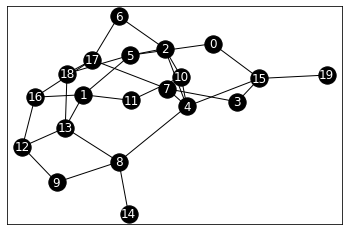

In [38]:
# 객체 생성
G = nx.Graph()

# 노드 설정
NUM = len(df_links.index)
for i in range(1,NUM+1):
    node_no = df_links.columns[i].strip("Node")
    G.add_node(str(node_no))


#엣지 설정 
for i in range(NUM):
    for j in range(NUM):
        node_name = "Node" + str(j)
        
        if df_links[node_name].iloc[i]==1:
            G.add_edge(str(i),str(j))
            
    
#그리기
nx.draw_networkx(G,node_color="k", edge_color="k", font_color="w")

#표시
plt.show()

In [39]:
import numpy as np

In [40]:
def determine_link(percent):
    rand_val = np.random.rand()
    if rand_val<=percent:
        return 1
    else:
        return 0

In [41]:
def simulate_percolation(num, list_active, percent_percolation):
    for i in range(num):
        if list_active[i]==1:
            for j in range(num):
                node_name = "Node" + str(j)
                if df_links[node_name].iloc[i]==1:
                    if determine_link(percent_percolation)==1:
                        list_active[j] = 1
    return list_active

In [42]:
percent_percolation = 0.1
T_NUM = 36
NUM = len(df_links.index)
list_active = np.zeros(NUM)
list_active[0] = 1

list_timeSeries = []
for t in range(T_NUM):
    list_active = simulate_percolation(NUM, list_active, percent_percolation)
    list_timeSeries.append(list_active.copy())

In [43]:
#엑티브 노드 가시화

def active_node_coloring(list_active):
    #print(list_timeSeries[t])
    list_color = []
    for i in range(len(list_timeSeries[t])):
        
        if list_timeSeries[t][i]==1:
            list_color.append("r")
        else:
            list_color.append("k")
    #print(len(liest_color))
    return list_color

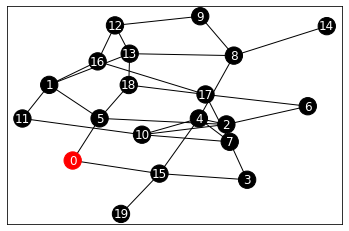

In [44]:
#그리기
t = 0
nx.draw_networkx(G,font_color="w",node_color=active_node_coloring(list_timeSeries[t]))
plt.show()

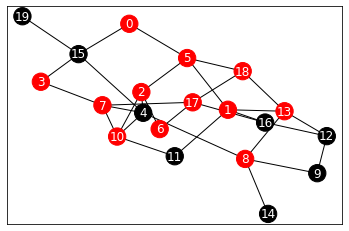

In [45]:
t = 11
nx.draw_networkx(G,font_color="w",node_color=active_node_coloring(list_timeSeries[t]))
plt.show()

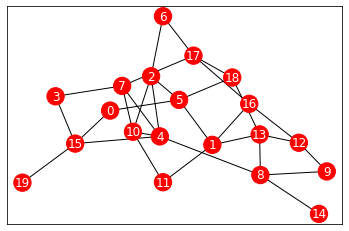

In [46]:
t = 35
nx.draw_networkx(G,font_color="w",node_color=active_node_coloring(list_timeSeries[t]))
plt.show()

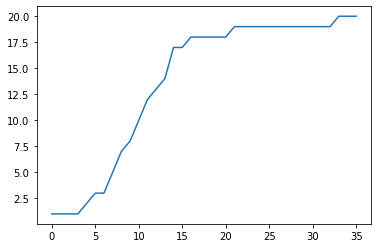

In [47]:
#입소문의 시계열 변화

list_timeSeries_num = []
for i in range(len(list_timeSeries)):
    list_timeSeries_num.append(sum(list_timeSeries[i]))
    
plt.plot(list_timeSeries_num)
plt.show()

In [48]:
def simulate_population(num, list_active, percent_percolation, percent_disapparence,df_links):
    #확산#
    for i in range(num):
        if list_active[i]==1:
            for j in range(num):
                node_name = "Node" + str(j)
                if df_links.iloc[i][j]==1:
                    if determine_link(percent_percolation)==1:
                        list_active[j] = 1
    #소멸#
    for i in range(num):
        if determine_link(percent_disapparence)==1:
            list_active[i] = 0
    return list_active

In [49]:
percent_percolation = 0.1
percent_disapparence = 0.05
T_NUM = 100
NUM = len(df_links.index)
list_active = np.zeros(NUM)
list_active[0] = 1

list_timeSeries = []
for t in range(T_NUM):
    list_active = simulate_population(NUM, list_active, percent_percolation, percent_disapparence,df_links)
    list_timeSeries.append(list_active.copy())

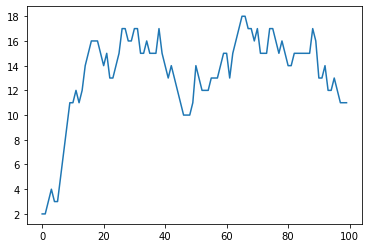

In [50]:
#입소문의 시계열 변화

list_timeSeries_num = []
for i in range(len(list_timeSeries)):
    list_timeSeries_num.append(sum(list_timeSeries[i]))
    
plt.plot(list_timeSeries_num)
plt.show()

In [51]:
percent_disapparence = 0.2
list_active = np.zeros(NUM)
list_active[0] = 1
list_timeSeries = []
for t in range(T_NUM):
    list_active = simulate_population(NUM, list_active, percent_percolation, percent_disapparence, df_links)
    list_timeSeries.append(list_active.copy())

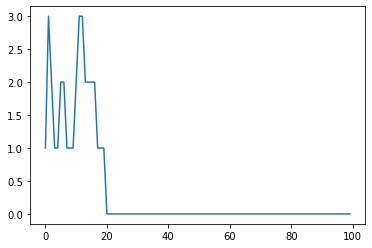

In [52]:
list_timeSeries_num = []
for i in range(len(list_timeSeries)):
    list_timeSeries_num.append(sum(list_timeSeries[i]))
    
plt.plot(list_timeSeries_num)
plt.show()

In [55]:
T_NUM = 100
NUM_PhaseDiagram = 20
phaseDiagram = np.zeros((NUM_PhaseDiagram,NUM_PhaseDiagram))
for i_p in range(NUM_PhaseDiagram):
    for i_d in range(NUM_PhaseDiagram):
        percent_percolation = 0.05*i_p
        percent_disapparence = 0.05*i_d
        list_active = np.zeros(NUM)
        list_active[0] = 1
        for t in range(T_NUM):
            list_active = simulate_population(NUM, list_active, percent_percolation, percent_disapparence, df_links)
        phaseDiagram[i_p][i_d] = sum(list_active)
print(phaseDiagram)

KeyboardInterrupt: 

In [ ]:
#표시
plt.matshow(phaseDiagram)
plt.colorbar(shrink=0.8)
plt.xlabel('percent_disapparence')
plt.ylabel('percent_percolation')
plt.xticks(np.arrange(0.0, 20, 0.5), np.arange(0.0, 1.0, 0.25))
plt.yticks(np.arrange(0.0, 20, 0.5), np.arange(0.0, 1.0, 0.25))
plt.tick_params(bottom=False, left=False, right=False, top=Flase)
plt.show()

In [57]:
df_mem_links = pd.read_csv("links_members.csv")
df_mem_info = pd.read_csv("info_members.csv")

In [58]:
NUM = len(df_mem_links.index)
array_linkNum = np.zeros(NUM)
for i in range(NUM):
    array_linkNum[i] = sum(df_mem_links["Node"+str(i)])

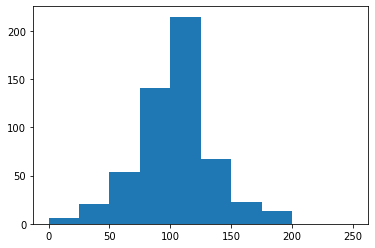

In [60]:
plt.hist(array_linkNum, bins=10,range=(0,250))
plt.show()

In [62]:
NUM = len(df_mem_info.index)
T_NUM = len(df_mem_info.columns)-1
#소멸 확률 추정
count_active = 0
count_active_to_inactive = 0
for t in range(1, T_NUM):
    for i in range(NUM):
        if (df_mem_info.iloc[i][t]==1):
            count_active_to_inactive += 1
            if (df_mem_info.iloc[i][t+1]==0):
                count_active += 1
estimated_percent_disapparence = count_active/count_active_to_inactive

In [67]:
#확산 확률 추정
count_link = 0
count_link_to_active = 0
count_link_temp = 0
for t in range(T_NUM-1):
    df_link_t = df_mem_info[df_mem_info[str(t)]==1]
    temp_flag_count = np.zeros(NUM)
    for i in range(len(df_link_t.index)):
        df_link_temp = df_mem_links[df_mem_links["Node"+str(df_link_t.index[i])]==1]
        for j in range(len(df_link_temp.index)):
            if (df_mem_info.iloc[df_link_temp.index[j]][t]==0):
                if (temp_flag_count[df_link_temp.index[j]]==0):
                        count_link += 1
                if (df_mem_info.iloc[df_link_temp.index[j]][t+1]==1):
                    if (temp_flag_count[df_link_temp.index[j]]==0):
                        temp_flag_count[df_link_temp.index[j]] = 1
                        count_link_to_active += 1
estimated_percent_percolation = count_link_to_active/count_link

In [68]:
estimated_percent_disapparence

0.10147163541419416

In [69]:
estimated_percent_percolation

0.025184661323275185

In [70]:
estimated_percent_percolation = 0.025184661323275185
estimated_percent_disapparence = 0.10147163541419416
T_NUM = 24
NUM = len(df_mem_links.index)
list_active = np.zeros(NUM)
list_active[0] = 1
list_timeSeries = []
for t in range(T_NUM):
    list_Active = simulate_population(NUM, list_active, percent_percolation, percent_disapparence, df_mem_links)
    list_timeSeries.append(list_active.copy())


KeyboardInterrupt: 

In [ ]:
list_timeSeries_num = []
for i in range(len(list_timeSeries)):
    list_timeSeries_num.append(sum(list_timeSeries[i]))

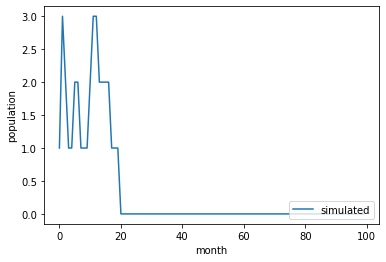

In [71]:
plt.plot(list_timeSeries_num, label = 'simulated')
plt.xlabel('month')
plt.ylabel('population')
plt.legend(loc='lower right')
plt.show()